# Amazon Reviews Topic Modeling with LDA

Online product reviews provide valuable insights for both consumers and sellers. However, due to the overwhelming volume of information, an intelligent system that identifies key topics from these reviews would be beneficial. This system would:
- Allow consumers to quickly grasp the main points without reading all the reviews.
- Provide sellers with consumer feedback in the form of extracted topics.

To solve this task, we will use the concept of **Topic Modeling** (**LDA**) on Amazon Automotive Review data.
- **Dataset** : [Amazon Automotive Review Dataset](http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Automotive_5.json.gz)

### Why use Topic Modeling for this task?

Topic Modeling is a method to automatically identify topics present within a text and derive the underlying patterns within a text corpus. Topic Modellling are useful for a variety of purposes, including:
- Clustering documents
- Organizing large amounts of textual data
- Retrieving information from unstructured text
- Selecting relevant features

For example, a well-trained topic model on text related to the stock market should yield topics such as “bid,” “trading,” “dividend,” “exchange,” etc.

![Topic Modelling](data/topic_modelling_image.webp)

In our case, we have thousands of online product reviews under the 'Automotive' category. Our goal is to extract several groups of key words from these reviews. These groups represent topics that will help us understand the main theme of discussions consumers are having in their reviews.

In [32]:
import os
import json
import gzip
import pandas as pd
# pd.set_option("display.max_colwidth", 200)
import numpy as np
import re

import nltk
from nltk import FreqDist
import spacy
import gensim
from gensim import corpora

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Data Loader functions:

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)
    
def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

In [3]:
# Load data:

df = getDF('data/reviews_Automotive_5.json.gz') 
df.shape

(20473, 9)

Data columns:
- **reviewerID** – ID of the reviewer
- **asin** – ID of the product
- **reviewerName** – name of the reviewer
- **helpful** – helpfulness rating of the review, e.g. 2/3
- **reviewText** – text of the review
- **overall** – rating of the product
- **summary** – summary of the review
- **unixReviewTime** – time of the review (unix time)
- **reviewTime** – time of the review (raw)

We will be using only the reviews column, i.e., `reviewText`.

In [4]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A3F73SC1LY51OO,B00002243X,Alan Montgomery,"[4, 4]",I needed a set of jumper cables for my new car...,5.0,Work Well - Should Have Bought Longer Ones,1313539200,"08 17, 2011"
1,A20S66SKYXULG2,B00002243X,alphonse,"[1, 1]","These long cables work fine for my truck, but ...",4.0,Okay long cables,1315094400,"09 4, 2011"
2,A2I8LFSN2IS5EO,B00002243X,Chris,"[0, 0]",Can't comment much on these since they have no...,5.0,Looks and feels heavy Duty,1374710400,"07 25, 2013"
3,A3GT2EWQSO45ZG,B00002243X,DeusEx,"[19, 19]",I absolutley love Amazon!!! For the price of ...,5.0,Excellent choice for Jumper Cables!!!,1292889600,"12 21, 2010"
4,A3ESWJPAVRPWB4,B00002243X,E. Hernandez,"[0, 0]",I purchased the 12' feet long cable set and th...,5.0,"Excellent, High Quality Starter Cables",1341360000,"07 4, 2012"


## Data Preprocessing

### Check the Most Frequent Words in the data

In [5]:
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

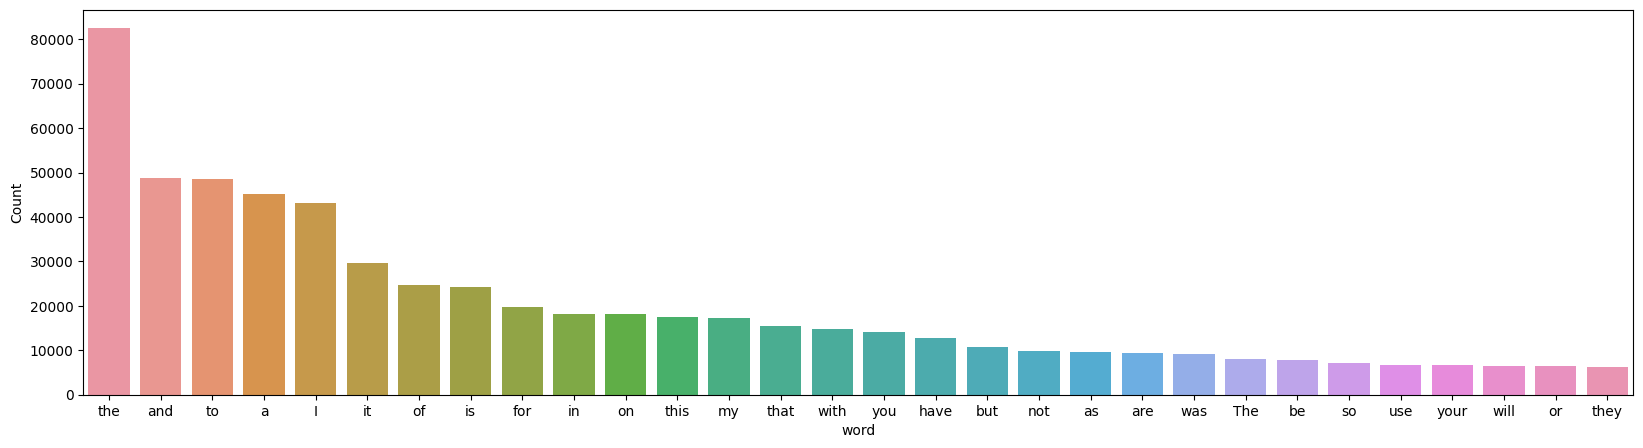

In [6]:
freq_words(df['reviewText'])

Most common words are ‘the’, ‘and’, ‘to’, etc. These words are not so important for our task and they do not provide any meaningful insights. Therefore, we need to remove these words to focus on more relevant terms.

### Removing the Punctuations and Numbers

In [7]:
# replace "n't" with " not":
df['reviewText'] = df['reviewText'].str.replace("n\'t", " not")

# remove unwanted characters, numbers and symbols:
df['reviewText'] = df['reviewText'].str.replace("[^a-zA-Z#]", " ")

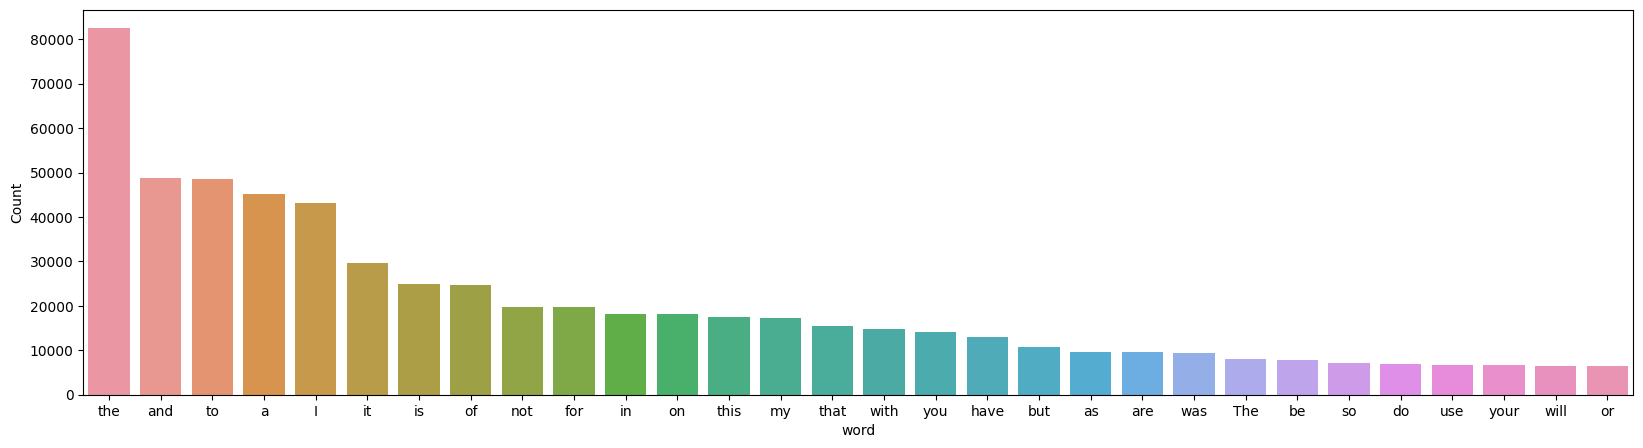

In [8]:
freq_words(df['reviewText'])

### Remove the Stopwords and Short Words (<3 letters)

In [9]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [10]:
# function to remove Stopwords:

def remove_stopwords(rev):
  rev_new = " ".join([i for i in rev if i not in stop_words])
  return rev_new

In [11]:
# remove short words (length < 3):

df['reviewText'] = df['reviewText'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# remove Stopwords from the text:
reviews = [remove_stopwords(r.split()) for r in df['reviewText']]

# make entire text Lowercase:
reviews = [r.lower() for r in reviews]

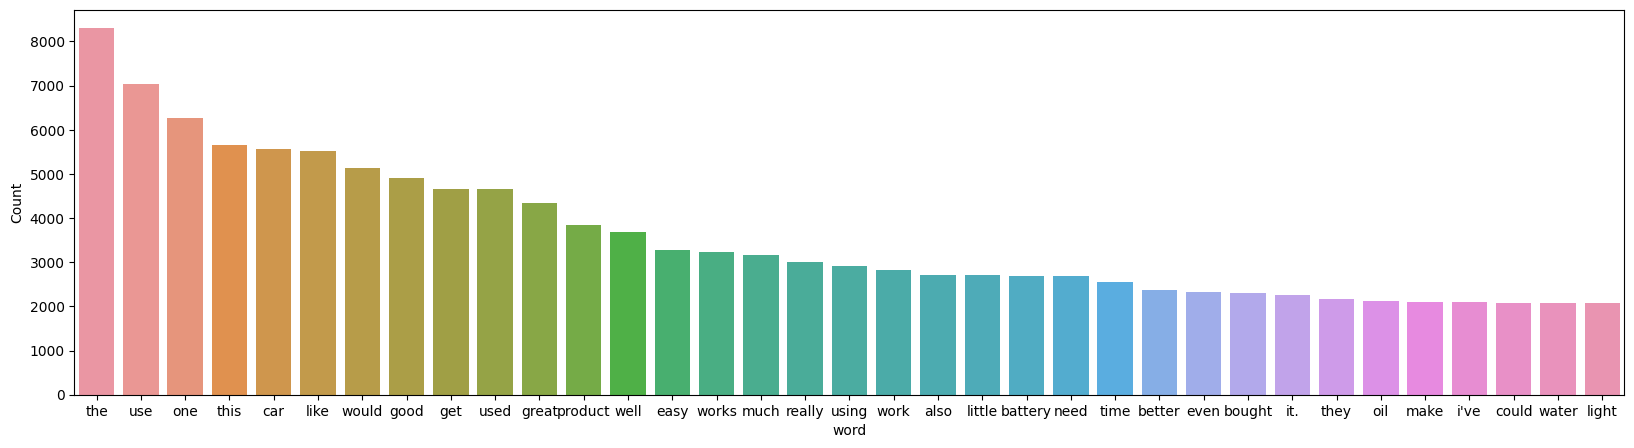

In [12]:
freq_words(reviews, 35)

We can see some improvement here. Terms like ‘battery’, ‘price’, ‘product’, ‘oil’ have come up which are quite relevant for the Automotive category. However, we still have neutral terms like ‘the’, ‘this’, ‘much’, ‘they’ which are not that relevant.

To further remove noise from the text we can use **Lemmatization** from the *spaCy* library. It reduces any given word to its base form thereby reducing multiple forms of a word to a single word.

In [ ]:
# Download SpaCy 'en_core_web_sm' Package : one time only

!python -m spacy download en_core_web_sm

In [17]:
# Load SpaCy English Model:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

### Lemmatization
- and consider only Noun and Adjectives

In [18]:
# Lemmatization function: consider only NOUN and ADJECTIVE words:

def lemmatization(texts, tags=['NOUN', 'ADJ']):
    output = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        output.append([token.lemma_ for token in doc if token.pos_ in tags])
    return output

In [19]:
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
print(tokenized_reviews[1])

['these', 'long', 'cables', 'work', 'fine', 'truck,', 'quality', 'seems', 'little', 'shabby', 'side.', 'for', 'money', 'expecting', '200', 'dollar', 'snap-on', 'jumper', 'cables', 'seem', 'like', 'would', 'see', 'chinese', 'knock', 'shop', 'like', 'harbor', 'freight', 'bucks.']


In [20]:
print(tokenized_reviews[1])
len(tokenized_reviews[1])

['these', 'long', 'cables', 'work', 'fine', 'truck,', 'quality', 'seems', 'little', 'shabby', 'side.', 'for', 'money', 'expecting', '200', 'dollar', 'snap-on', 'jumper', 'cables', 'seem', 'like', 'would', 'see', 'chinese', 'knock', 'shop', 'like', 'harbor', 'freight', 'bucks.']


30

In [21]:
reviews_2 = lemmatization(tokenized_reviews)
print(reviews_2[1])

['long', 'cable', 'fine', 'truck', 'quality', 'little', 'shabby', 'side', 'money', 'dollar', 'snap', 'jumper', 'cable', 'shop', 'freight', 'buck']


In [22]:
print(reviews_2[1])
len(reviews_2[1])

['long', 'cable', 'fine', 'truck', 'quality', 'little', 'shabby', 'side', 'money', 'dollar', 'snap', 'jumper', 'cable', 'shop', 'freight', 'buck']


16

In [23]:
# Words removed in the first data text after Lemmatization:
set(tokenized_reviews[1]) - set(reviews_2[1])

{'200',
 'bucks.',
 'cables',
 'chinese',
 'expecting',
 'for',
 'harbor',
 'knock',
 'like',
 'see',
 'seem',
 'seems',
 'side.',
 'snap-on',
 'these',
 'truck,',
 'work',
 'would'}

In [24]:
reviews_3 = []
for i in range(len(reviews_2)):
    reviews_3.append(' '.join(reviews_2[i]))
    
df['reviews'] = reviews_3

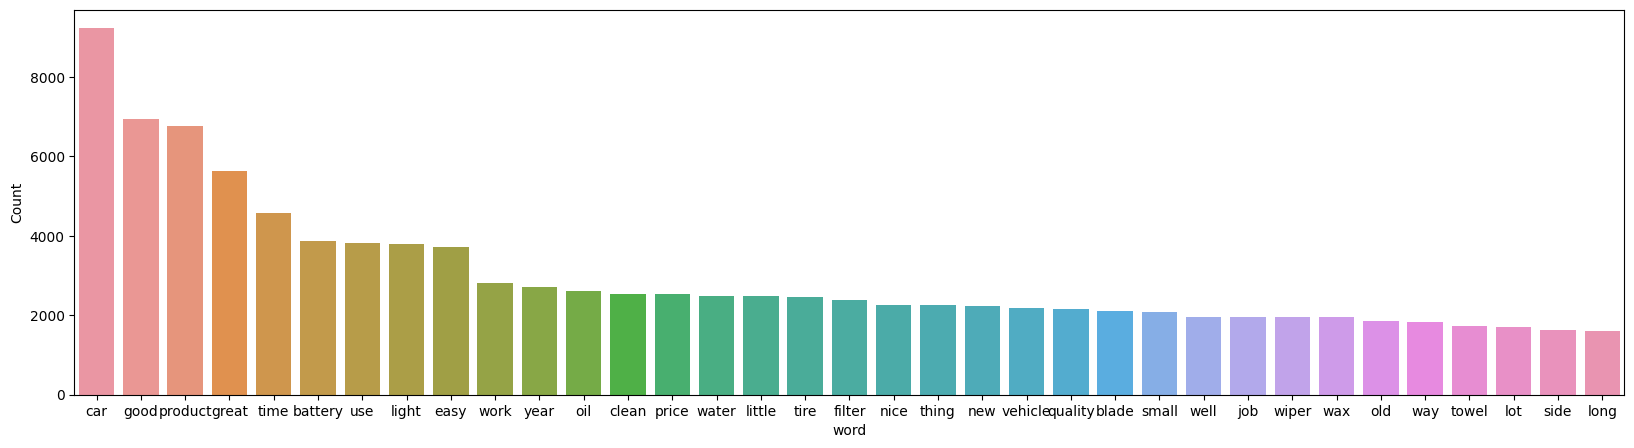

In [25]:
freq_words(df['reviews'], 35)

Now it seems that now most frequent terms in our data are relevant. We can now go ahead and start building our topic model.

## Building an LDA model

In [26]:
# Create the term dictionary of our corpus, where every unique term is assigned an index:
dictionary = corpora.Dictionary(reviews_2)

Building **Document - Term Matrix**:

In [27]:
# Convert list of reviews (reviews_2) into a Document Term Matrix using the dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_2]

In [28]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

Building **LDA Model** with **Number of Topics** = **7**

In [29]:
# Build LDA model
lda_model = LDA(corpus=doc_term_matrix,
                id2word=dictionary,
                num_topics=7, 
                random_state=100,
                chunksize=1000,
                passes=50)

### Topics that the LDA Model has learned

In [30]:
lda_model.print_topics()

[(0,
  '0.045*"light" + 0.029*"blade" + 0.026*"wiper" + 0.017*"good" + 0.015*"bright" + 0.013*"bulb" + 0.013*"price" + 0.012*"great" + 0.010*"year" + 0.009*"windshield"'),
 (1,
  '0.030*"car" + 0.016*"code" + 0.014*"plug" + 0.012*"device" + 0.012*"engine" + 0.011*"vehicle" + 0.010*"app" + 0.010*"tool" + 0.010*"wire" + 0.008*"datum"'),
 (2,
  '0.058*"battery" + 0.030*"power" + 0.028*"oil" + 0.024*"car" + 0.020*"filter" + 0.016*"charger" + 0.015*"unit" + 0.015*"phone" + 0.013*"device" + 0.012*"charge"'),
 (3,
  '0.053*"leather" + 0.044*"water" + 0.030*"hose" + 0.021*"tank" + 0.017*"seat" + 0.015*"cap" + 0.011*"conditioner" + 0.010*"grease" + 0.009*"carpet" + 0.009*"nozzle"'),
 (4,
  '0.044*"car" + 0.033*"product" + 0.019*"good" + 0.018*"towel" + 0.015*"clean" + 0.015*"great" + 0.012*"time" + 0.012*"wax" + 0.011*"use" + 0.009*"water"'),
 (5,
  '0.057*"wheel" + 0.040*"pad" + 0.030*"brush" + 0.024*"brake" + 0.023*"inverter" + 0.015*"bar" + 0.014*"bucket" + 0.010*"lint" + 0.009*"grit" + 0.00

- Topic 0 seems to be about the utilities as it has terms like light, wiper, and windshield.
- Topic 4 has terms like ‘towel’, ‘clean’, ‘wax’, ‘water’, indicating that the topic is very much related to car-wash. 

### Topics Visualization

To visualize our topics in a 2-dimensional space we will use the **pyLDAvis** library. This visualization is interactive in nature and displays topics along with the most relevant words.

In [33]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.158201 -0.064171       1        1  27.301228
6      0.157543 -0.006235       2        1  26.526034
0      0.168389 -0.007235       3        1  15.791007
2      0.100971  0.034393       4        1  12.349125
1      0.006760  0.172084       5        1   7.910262
3     -0.234952 -0.313760       6        1   5.843247
5     -0.356912  0.184925       7        1   4.279096, topic_info=           Term         Freq        Total Category  logprob  loglift
32      battery  3629.000000  3629.000000  Default  30.0000  30.0000
4           car  9215.000000  9215.000000  Default  29.0000  29.0000
508       water  2543.000000  2543.000000  Default  28.0000  28.0000
141       light  4795.000000  4795.000000  Default  27.0000  27.0000
1298    leather  1576.000000  1576.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
496        dust   173.897642   521.977669   Topic7  -4.8214   2.0523
663        soft   122.680487   738.261131   Topic7  -5.1703   1.3567
820      bottom   101.623654   382.752021   Topic7  -5.3586   1.8253
1194       inch    89.108694   541.833130   Topic7  -5.4900   1.3463
3484  important    82.897989   237.080846   Topic7  -5.5623   2.1006

[406 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
553       1  0.305587       -
553       2  0.234450       -
553       3  0.166319       -
553       4  0.029056       -
553       5  0.236454       -
...     ...       ...     ...
258       3  0.339230    year
258       4  0.190429    year
258       6  0.075729    year
1506      1  0.240083  yellow
1506      3  0.757976  yellow

[583 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 7, 1, 3, 2, 4, 6])

In [34]:
# Print the Keyword in the 10 topics
lda_model.print_topics()

[(0,
  '0.045*"light" + 0.029*"blade" + 0.026*"wiper" + 0.017*"good" + 0.015*"bright" + 0.013*"bulb" + 0.013*"price" + 0.012*"great" + 0.010*"year" + 0.009*"windshield"'),
 (1,
  '0.030*"car" + 0.016*"code" + 0.014*"plug" + 0.012*"device" + 0.012*"engine" + 0.011*"vehicle" + 0.010*"app" + 0.010*"tool" + 0.010*"wire" + 0.008*"datum"'),
 (2,
  '0.058*"battery" + 0.030*"power" + 0.028*"oil" + 0.024*"car" + 0.020*"filter" + 0.016*"charger" + 0.015*"unit" + 0.015*"phone" + 0.013*"device" + 0.012*"charge"'),
 (3,
  '0.053*"leather" + 0.044*"water" + 0.030*"hose" + 0.021*"tank" + 0.017*"seat" + 0.015*"cap" + 0.011*"conditioner" + 0.010*"grease" + 0.009*"carpet" + 0.009*"nozzle"'),
 (4,
  '0.044*"car" + 0.033*"product" + 0.019*"good" + 0.018*"towel" + 0.015*"clean" + 0.015*"great" + 0.012*"time" + 0.012*"wax" + 0.011*"use" + 0.009*"water"'),
 (5,
  '0.057*"wheel" + 0.040*"pad" + 0.030*"brush" + 0.024*"brake" + 0.023*"inverter" + 0.015*"bar" + 0.014*"bucket" + 0.010*"lint" + 0.009*"grit" + 0.00